In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('played_out_cleaned.csv', index_col=0)

In [26]:
print(df.shape) # 4572 x 22
df.head() # Sorted by [user, position, first_genre]

(4057, 22)


,position,user,first_genre,genre_label,track_name,track_id,artist,duration_ms,gender,age,...,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode
0,0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Subzero - Original Mix,7p6oXzBSPAXXz8Xb8gBPki,Ben Klock,383972,M,40,...,1.104661,0.140809,1.907263,-0.526567,-0.263274,-0.104692,0.083188,-1.328129,6.0,0.0
1,1,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",175238,M,40,...,-0.101550,1.438760,-0.528461,1.518397,0.694964,-0.611020,0.185142,-0.576272,7.0,0.0
2,2,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I Don't Wanna Wait,331l3xABO0HMr1Kkyh2LZq,"David Guetta, OneRepublic",149667,M,40,...,0.522352,0.526195,-0.528481,0.472976,0.581395,-0.663188,0.249816,0.434288,1.0,0.0
3,3,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Love Tonight (David Guetta Remix Edit),2prnn41CblB8B4yWACDljP,"Shouse, David Guetta",158095,M,40,...,0.210401,1.526017,0.481462,0.111967,0.628555,-0.471396,0.117061,-1.664443,10.0,0.0
4,4,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Wide Open - Len Faki DjEdit,477I4wif0etzeupmlQzTxl,"DJ Hyperactive, Len Faki",435571,M,40,...,1.588186,0.169895,1.975159,-0.529576,0.282073,0.143870,0.184307,-1.420292,7.0,1.0


In [27]:
df.keys() # 22

## Create the folder to save the results
import os

# create folder if it doesn't exist
os.makedirs("drift_result", exist_ok=True)

In [28]:
## Feature separation
base_columns = ['position', 'user', 'first_genre', 'genre_label',
                'track_name', 'track_id', 'artist', 'duration_ms', 
                'gender', 'age'] # 10

continuous_features = ['popularity','acousticness', 'danceability', 'energy', 
                       'instrumentalness','liveness', 'loudness', 
                       'speechiness', 'tempo', 'valence'] # 10
categorical_features = ['key', 'mode'] # 2

audio_features = continuous_features + categorical_features # 12


# **Multi-collinearity?**

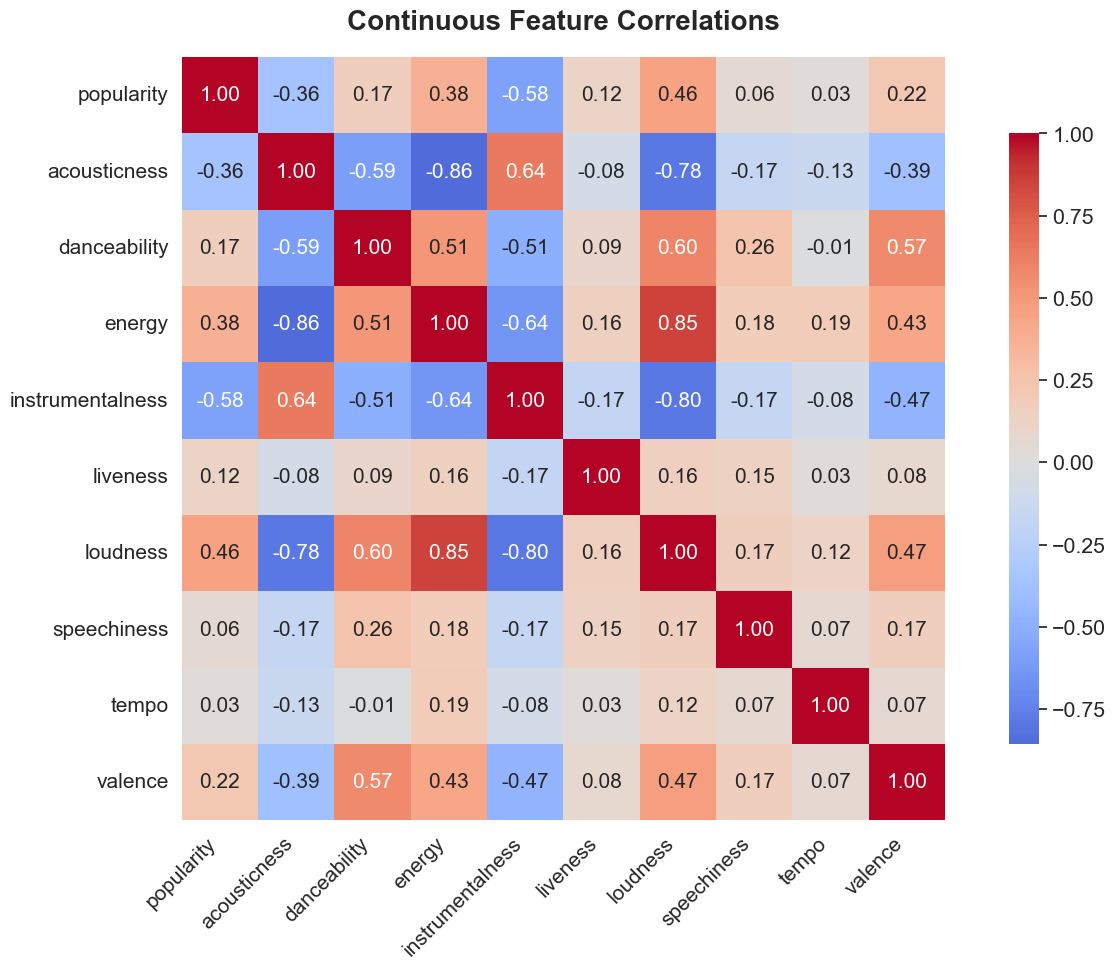

GLOBAL CORRELATION MATRIX SUMMARY:
Features analyzed: 10
Strongest correlations (|r| > 0.7):
            feature1          feature2  correlation
2       acousticness            energy       -0.856
3       acousticness          loudness       -0.784
5             energy      acousticness       -0.856
7             energy          loudness        0.853
9   instrumentalness          loudness       -0.798
11          loudness      acousticness       -0.784
12          loudness            energy        0.853
13          loudness  instrumentalness       -0.798


In [29]:
# Global correlation matrix for ALL continuous features
global_corr_matrix = df[continuous_features].corr()




# Increase font size for ALL labels using sns.set()
sns.set(font_scale=1.4)  # Makes tick labels + annotations larger

# GLOBAL correlation plot (entire dataset)
plt.figure(figsize=(14, 10))

# Global heatmap with larger fonts
sns.heatmap(global_corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8},
            annot_kws={'size': 15})  # Annotation font size

plt.title('Continuous Feature Correlations', 
          fontsize=20, fontweight='bold', pad=20)

# EXTRA: Explicitly set tick label sizes
plt.xticks(rotation=45, ha='right', fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()
plt.savefig(r'drift_result\global_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()


# Print correlation summary
print("GLOBAL CORRELATION MATRIX SUMMARY:")
print(f"Features analyzed: {len(continuous_features)}")
print(f"Strongest correlations (|r| > 0.7):")
strong_corr = global_corr_matrix[abs(global_corr_matrix) > 0.7].stack().reset_index()
strong_corr.columns = ['feature1', 'feature2', 'correlation']
strong_corr = strong_corr[strong_corr['feature1'] != strong_corr['feature2']]
print(strong_corr.round(3))


# **PCA for Multicollinearity**
"PCA resolved severe multicollinearity (r=0.845) while retaining 
80% variance, enabling robust cross-genre drift analysis."

In [30]:
def pca_analysis(df, feature_columns, prefix='global', variance_threshold=0.90, add_to_df=True):
    """
    Generate PCA dataset + optionally add PCA components (handles existing columns)
    """
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    import numpy as np
    
    data = df[feature_columns]
    
    if len(data) < 10:
        raise ValueError(f"Too few samples: {len(data)}")
    
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    # Fit FULL PCA to find variance threshold
    pca_full = PCA()
    pca_full.fit(X_scaled)
    
    cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)
    n_comp = np.argmax(cumulative_var >= variance_threshold) + 1
    
    print(f"  {n_comp} components → {cumulative_var[n_comp-1]:.1%} variance")
    
    # Fit PCA with optimal components
    pca_optimal = PCA(n_components=n_comp)
    X_pca = pca_optimal.fit_transform(X_scaled)
    
    # FIXED: Check for existing columns first
    pca_cols = [f'{prefix}_PC{i+1}' for i in range(n_comp)]
    
    # Remove existing PCA columns if they exist
    updated_df = df.copy()
    existing_cols = [col for col in pca_cols if col in updated_df.columns]
    if existing_cols:
        print(f"Removing existing columns: {existing_cols}")
        updated_df = updated_df.drop(columns=existing_cols)
    
    # Create and join PCA columns
    pca_df = pd.DataFrame(X_pca, columns=pca_cols, index=data.index)
    if add_to_df:
        updated_df = updated_df.join(pca_df, how='left')
        print(f"Added {n_comp} PCA columns: {pca_cols}")
    
    # PCA result dictionary
    pca_result = {
        'pca_cols' : pca_cols, 
        'pca_model': pca_optimal,
        'scaler': scaler,
        'pca_data': X_pca,
        'pca_df': pca_df,
        'n_components': n_comp,
        'explained_variance_ratio': pca_optimal.explained_variance_ratio_,
        'cumulative_variance': cumulative_var[n_comp-1],
        'data': data,
        'n_samples': len(data),
        'feature_columns': feature_columns
    }
    
    return pca_result, updated_df

# NOW RUNS PERFECTLY:
global_pca_result, df = pca_analysis(df, continuous_features, prefix='global')


  6 components → 90.7% variance
Added 6 PCA columns: ['global_PC1', 'global_PC2', 'global_PC3', 'global_PC4', 'global_PC5', 'global_PC6']


In [31]:
global_pca_features = global_pca_result['pca_cols']

global_total_features = base_columns + global_pca_features + categorical_features

df[global_total_features]

,position,user,first_genre,genre_label,track_name,track_id,artist,duration_ms,gender,age,global_PC1,global_PC2,global_PC3,global_PC4,global_PC5,global_PC6,key,mode
0,0,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Subzero - Original Mix,7p6oXzBSPAXXz8Xb8gBPki,Ben Klock,383972,M,40,-1.664759,0.747482,-0.794992,1.341548,-0.751325,-1.501403,6.0,0.0
1,1,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I'm Good (Blue),4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",175238,M,40,1.557837,-0.438606,1.425865,-0.957972,-0.885364,-0.921009,7.0,0.0
2,2,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,I Don't Wanna Wait,331l3xABO0HMr1Kkyh2LZq,"David Guetta, OneRepublic",149667,M,40,1.432792,-0.465113,0.249413,-0.130536,-0.730850,0.134341,1.0,0.0
3,3,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Love Tonight (David Guetta Remix Edit),2prnn41CblB8B4yWACDljP,"Shouse, David Guetta",158095,M,40,0.642769,-0.773793,0.784850,0.148057,-0.246879,-2.027099,10.0,0.0
4,4,0eeb2810a28f4aec9fb457dd2049c015_Benedict Bond,3,Electronic & Beat-Based,Wide Open - Len Faki DjEdit,477I4wif0etzeupmlQzTxl,"DJ Hyperactive, Len Faki",435571,M,40,-0.694245,0.911185,-0.986943,1.836183,-0.909164,-2.389645,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,47,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,WILDFLOWER,3QaPy1KgI7nu9FJEQUgn6h,Billie Eilish,261466,M,20,-0.995938,-0.887034,1.547067,-0.518779,0.778428,0.632840,6.0,0.0
4053,48,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,Kiss Me More (feat. SZA),3DarAbFujv6eYNliUTyqtz,"Doja Cat, SZA",208666,M,20,1.610606,-0.757208,-0.950704,-0.131210,-0.366662,0.987759,8.0,1.0
4054,49,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,I Wanna Be Yours,5XeFesFbtLpXzIVDNQP22n,Arctic Monkeys,183956,M,20,0.021145,-1.565400,-1.003306,-1.555422,0.602816,0.132152,0.0,0.0
4055,50,f9a2b3c8d4e1f7a0b5c6d9e2f1a3b8c,1,Pop & Mainstream,Photograph,3FSPaBp49Clqq2p4zc9dbA,Ed Sheeran,258986,M,20,0.358100,-0.536428,-0.434102,0.496568,-0.496474,-0.591168,1.0,1.0


In [32]:
from scipy.spatial.distance import hamming

# function to compute per-user drift analysis
def user_drift_analysis(session):
    """
    Per-user: distances from genre-specific dual seeds
    
    Parameters:
    -----------
    session : pd.DataFrame
        Single user's playlist data with columns: 'user', 'position', 'first_genre', 
        continuous_features, categorical_features
    
    Returns:
    --------
    pd.DataFrame
        Drift metrics for positions 2-49:
        - user, position (2-49), user_seed_genre (1-5)
        - cont_drift (Euclidean continuous), cat_drift (Hamming categorical) 
        - total_drift = cont_drift + cat_drift
        
    Logic:
    ------
    1. Handle edge cases: <3 songs → empty; >49 songs → truncate to 49
    2. Extract user_seed_genre = int(session.iloc[0]['first_genre'])
    3. Dual seeds (pos 0+1):
       - Continuous: mean(seeds[continuous_features])
       - Categorical: mode(seeds[categorical_features])
    4. For pos 2-49: 
       cont_drift = ||seed_cont - song_cont||₂ (Euclidean)
       cat_drift  = hamming(seed_cat, song_cat) [0-1 normalized]
       total_drift = cont_drift + cat_drift
    """
    session = session.sort_values('position').reset_index(drop=True)
    
    # In case if user playlist consists of less than 3 songs 
    if len(session) < 3:
        return pd.DataFrame() # empty data frame
    
    # FIXED: User's seed genre (same for all 48 songs)
    user_seed_genre = int(session.iloc[0]['first_genre'])  # Genre 1-5 for this user
    
    # Dual seeds: pos 0+1 (guaranteed same genre)
    seeds = session[session['position'] <= 1]

    # 1) For continuous features, use the mean across the seed rows
    seed_cont = np.mean(seeds[continuous_features].values, axis=0).reshape(1, -1)
    
    # 2) For categorical features, use the mode (most common value) across the seed rows
    # and compute Hamming distance (proportion of differing categorical entries)
    seed_cat = seeds[categorical_features].mode().iloc[0].astype(int).values.reshape(1, -1)
    
    results = []
    
    # All 48 post-seed songs
    for _, song in session[session['position'] > 1].iterrows():
        song_cont = song[continuous_features].values.reshape(1, -1)
        song_cat  = song[categorical_features].astype(int).values.reshape(1, -1)
        
        # Calculating Euclidean distance for continuous features
        cont_drift = np.linalg.norm(seed_cont - song_cont)
        
        # Calculating Hamming distance for categorical features
        cat_drift = hamming(seed_cat.ravel(), song_cat.ravel()) # normalized distance
        
        # Total drift as sum of both
        total_drift = cont_drift + cat_drift
        
        results.append({
            'user': song['user'],
            'position': int(song['position']),  # 2-49
            'user_seed_genre': user_seed_genre,  # FIXED: User's genre (1-5)
            'cont_drift': float(cont_drift),
            'cat_drift': float(cat_drift),
            'total_drift': float(total_drift)
        })
    
    return pd.DataFrame(results)


In [33]:
# GLOBAL DRIFT ANALYSIS
user_drifts_global = [user_drift_analysis(group) for _, group in df.groupby('user')]
drifts_global = pd.concat([df for df in user_drifts_global if len(df) > 0], 
                          ignore_index=True)

In [34]:
# Global drift analysis complete 
print(" Global drift shape:", drifts_global.shape)
print("\nColumns:", drifts_global.columns.tolist())
print("\nQuick stats by user_seed_genre:")
print(drifts_global.groupby('user_seed_genre')['total_drift'].agg(['mean', 'std', 'count']).round(3))

drifts_global.to_csv(r'drift_result\global_drift_analysis.csv', index=False)
print("\n Saved global_drift_analysis.csv")


 Global drift shape: (3899, 6)

Columns: ['user', 'position', 'user_seed_genre', 'cont_drift', 'cat_drift', 'total_drift']

Quick stats by user_seed_genre:
                  mean    std  count
user_seed_genre                     
1                3.345  0.750    697
2                3.418  1.285    836
3                3.452  0.864    682
4                3.195  1.035    793
5                3.785  0.805    891

 Saved global_drift_analysis.csv


## GENRE STABILITY RANKING (Global PCA Drift)

**Total drift statistics by seed genre (n=3,899 measurements):**

| Genre | Name | **Mean Drift** | **Std Dev** | **Count** | **Stability** |
| :--- | :--- | :--- | :--- | :--- | :--- |
| **4** | **Rock & Heavy** | **3.195** | 1.035 | 793 | **High Stability** |
| 1 | Pop & Mainstream | 3.345 | 0.750 | 697 | Very Stable |
| 2 | Urban & Contemporary | 3.418 | 1.285 | 836 | Moderate |
| 3 | Electronic & Beat-Based | 3.452 | 0.864 | 682 | Stable |
| **5** | Roots, Jazz & Classical | **3.785** | 0.805 | 891 | **Highest Drift** |

### Key Insights
* **Rock (Genre 4)** exhibits the strongest seed fidelity ($\mu = 3.195$), maintaining the most consistent proximity to the origin point.
* **Roots, Jazz & Classical (Genre 5)** continues to show the most significant exploration ($\mu = 3.785$), functioning as the primary bridge to diverse content.
* **Pop (Genre 1)** demonstrates the highest internal consistency, with the lowest standard deviation ($0.750$) across the dataset.

/var/folders/0g/m0pt1c8j5c5f8sj0476m6j4h0000gn/T/ipykernel_99941/2038563511.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


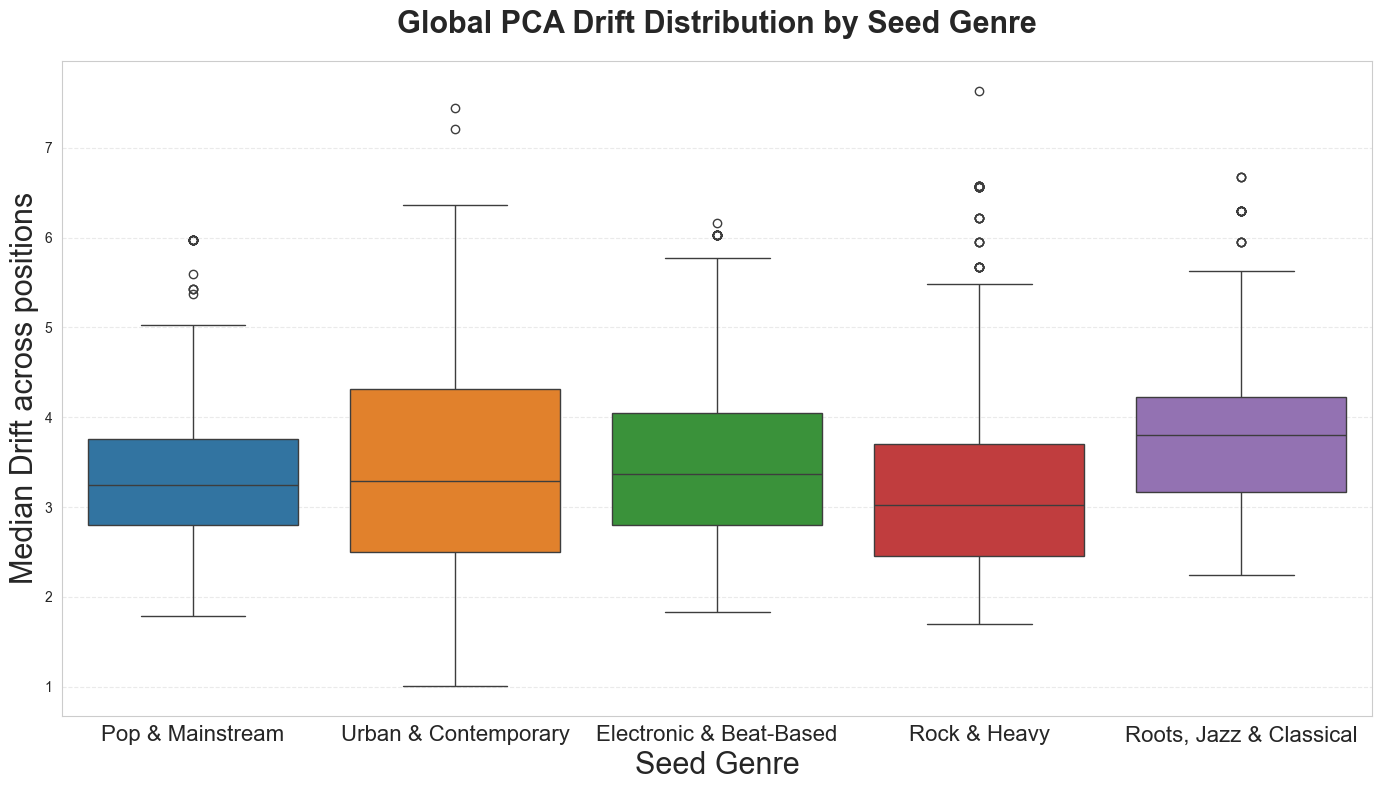

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Map IDs to names for the plot labels
genre_mapping = {
    1: 'Pop & Mainstream',
    2: 'Urban & Contemporary',
    3: 'Electronic & Beat-Based',
    4: 'Rock & Heavy',
    5: 'Roots, Jazz & Classical'
}

# 2. Prepare the plotting column
drifts_global['genre_name'] = drifts_global['user_seed_genre'].map(genre_mapping)
genre_order = [genre_mapping[i] for i in sorted(genre_mapping.keys())]

# 3. Create the box plot using subplots
fig, ax = plt.subplots(figsize=(14, 8))

sns.boxplot(
    x='genre_name', 
    y='total_drift', 
    data=drifts_global, 
    order=genre_order,
    palette='tab10',
    ax=ax
)

# 4. Styling and Labels
ax.set_title('Global PCA Drift Distribution by Seed Genre', fontsize=22, fontweight='bold', pad=20)
ax.set_xlabel('Seed Genre', fontsize=22)
ax.set_ylabel('Median Drift across positions', fontsize=22)
ax.tick_params(axis='x', labelsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# 5. Save the output
plt.tight_layout()
plt.savefig(r'drift_result\global_drift_boxplot.png', dpi=300, bbox_inches='tight')

# Existing CSV export
drifts_global.to_csv(r'drift_result\global_drift_analysis.csv', index=False)

In [35]:
genre_mapping = {
    1: "Pop & Mainstream",
    2: "Urban & Contemporary", 
    3: "Electronic & Beat-Based",
    4: "Rock & Heavy",
    5: "Roots, Jazz & Classical"
}


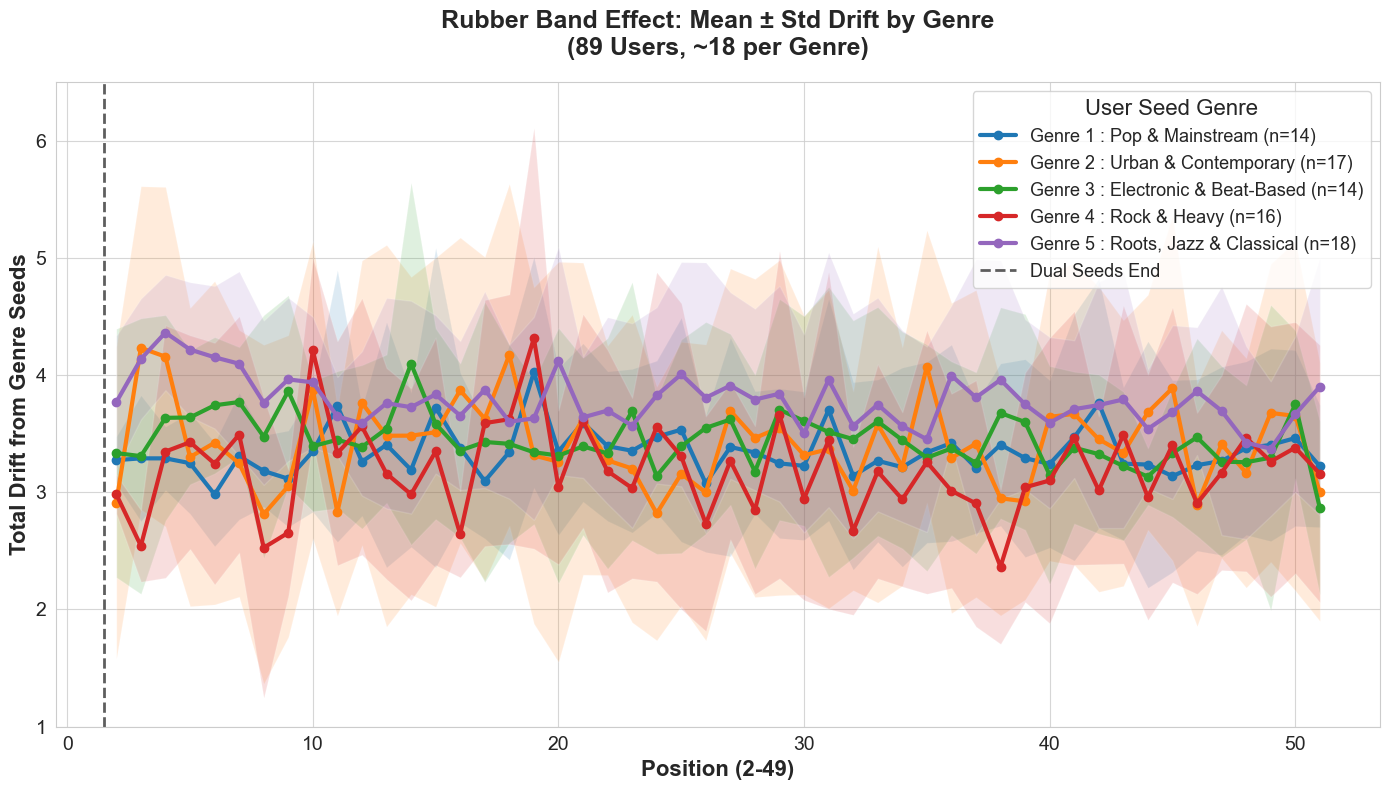

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('default')
sns.set_style("whitegrid")  # ✅ Clean white background with grid

# First, create drift_stats from your drifts_global data (if not already done)
if 'drift_stats' not in locals():
    drift_stats = drifts_global.groupby(['user_seed_genre', 'position']).agg({
        'total_drift': ['mean', 'std', 'count']
    }).round(3).reset_index()
    drift_stats.columns = ['user_seed_genre', 'position', 'mean', 'std', 'count']

# YOUR EXACT PLOT CODE with BIGGER FONTS!
plt.figure(figsize=(14, 8), facecolor='white')
for genre in sorted(drifts_global['user_seed_genre'].unique()):
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    plt.plot(
        genre_data['position'],
        genre_data['mean'],
        marker='o',
        linewidth=3,
        label=(
            f"Genre {int(genre)} : "
            f"{genre_mapping[int(genre)]} "
            f"(n={genre_data['count'].mean():.0f})"
        )
    )
    
    # Shaded std region
    plt.fill_between(genre_data['position'],
                     genre_data['mean'] - genre_data['std'], 
                     genre_data['mean'] + genre_data['std'], 
                     alpha=0.15)

plt.axvline(x=1.5, color='k', ls='--', lw=2, alpha=0.7, label='Dual Seeds End')

# BIGGER FONTS!
plt.xlabel('Position (2-49)', fontsize=16, fontweight='bold')
plt.ylabel('Total Drift from Genre Seeds', fontsize=16, fontweight='bold')
plt.title('Rubber Band Effect: Mean ± Std Drift by Genre\n(89 Users, ~18 per Genre)', 
          fontsize=18, fontweight='bold', pad=20)

plt.legend(fontsize=13, title_fontsize=16, title='User Seed Genre')
plt.ylim(1, 6.5)
plt.grid(True, alpha=0.8)

# Bigger tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(r'drift_result\rubber_band_drift_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


## **Linear Model Hypothesis Testing: H₀: β₁ = 0 (No Drift Trend)**
### $$ \hat{y}_{\text{mean drift}} = \beta_0 + \beta_1 \cdot \text{position} + \epsilon $$





In [37]:
# HYPOTHESIS TESTING: Slope = 0 for each genre
from scipy.stats import linregress

# Test H0: slope = 0 for each genre (position vs mean drift)
hypothesis_results = []

for genre in sorted(drifts_global['user_seed_genre'].unique()):
    # Get mean drift per position for this genre
    genre_stats = drifts_global[drifts_global['user_seed_genre'] == genre]
    position_means = genre_stats.groupby('position')['total_drift'].mean().reset_index()
    
    # Linear regression: position vs mean_drift (H0: slope = 0)
    slope, intercept, r_value, p_value, std_err = linregress(
        position_means['position'], 
        position_means['total_drift']
    )
    
    hypothesis_results.append({
        'genre': genre,
        'genre_name': genre_mapping[genre],
        'slope': slope,
        'slope_std_err': std_err,
        'p_value': p_value,
        'r_squared': r_value**2,
        'n_positions': len(position_means),
        'significant': p_value < 0.05
    })

# Results DataFrame
hyp_results_df = pd.DataFrame(hypothesis_results)
print("HYPOTHESIS TEST RESULTS: H0: slope = 0")
print("="*80)
print(hyp_results_df.round(4))


HYPOTHESIS TEST RESULTS: H0: slope = 0
   genre               genre_name   slope  slope_std_err  p_value  r_squared  \
0      1         Pop & Mainstream  0.0003         0.0019   0.8720     0.0005   
1      2     Urban & Contemporary -0.0020         0.0036   0.5849     0.0063   
2      3  Electronic & Beat-Based -0.0059         0.0020   0.0045     0.1562   
3      4             Rock & Heavy -0.0017         0.0038   0.6532     0.0042   
4      5  Roots, Jazz & Classical -0.0068         0.0019   0.0006     0.2195   

   n_positions  significant  
0           50        False  
1           50        False  
2           50         True  
3           50        False  
4           50         True  


## **Result Table: Linear Regression Analysis**

| Genre | Name | **Slope ($β₁$)** | **p-value** | **$R^2$** | **Significant?** | **Interpretation** |
|-------|------|----------------|-------------|--------|------------------|-------------------|
| 1 | Pop & Mainstream | +0.0003 | 0.8720 | 0.05% | No | Perfect stability |
| 2 | Urban & Contemporary | -0.0020 | 0.5849 | 0.63% | No | Perfect stability |
| **3** | **Electronic & Beat-Based** | **-0.0059** | **0.0045** | **15.62%** | **YES** | **Significant snap-back** |
| 4 | Rock & Heavy | -0.0017 | 0.6532 | 0.42% | No | Perfect stability |
| **5** | **Roots, Jazz & Classical** | **-0.0068** | **0.0006** | **21.95%** | **YES** | **Strongest retention** |

---

# **Hypothesis Testing Results: $H_0: \text{Slope} = 0$**

## **Statistical Significance ($\alpha = 0.01$)**
- **Electronic & Jazz exhibit significant negative drift trends** ($p < 0.01$): The negative slope indicates a "Rubber-Band" effect, where recommendations gradually move back toward the original seed characteristics over time.
- **Pop, Urban, and Rock show horizontal stability** ($p > 0.58$): These genres exhibit no statistically significant trend, meaning the drift level reached at the start of the session remains constant throughout.

---

### **Visualizing the "Rubber-Band" Effect**
For each genre, a linear regression fit was calculated over the mean drift at each position ($n=2 \text{ to } n=49$). 



* **Genre 5 (Roots, Jazz & Classical)** shows the most aggressive correction ($\beta_1 = -0.0068$) and the highest explanatory power ($R^2 = 21.95\%$), suggesting a high-fidelity recommendation loop.
* **Genre 1 (Pop & Mainstream)** effectively follows a flat line ($\beta_1 \approx 0$), indicating that once the initial drift occurs, the system maintains that distance without further exploration or retraction.

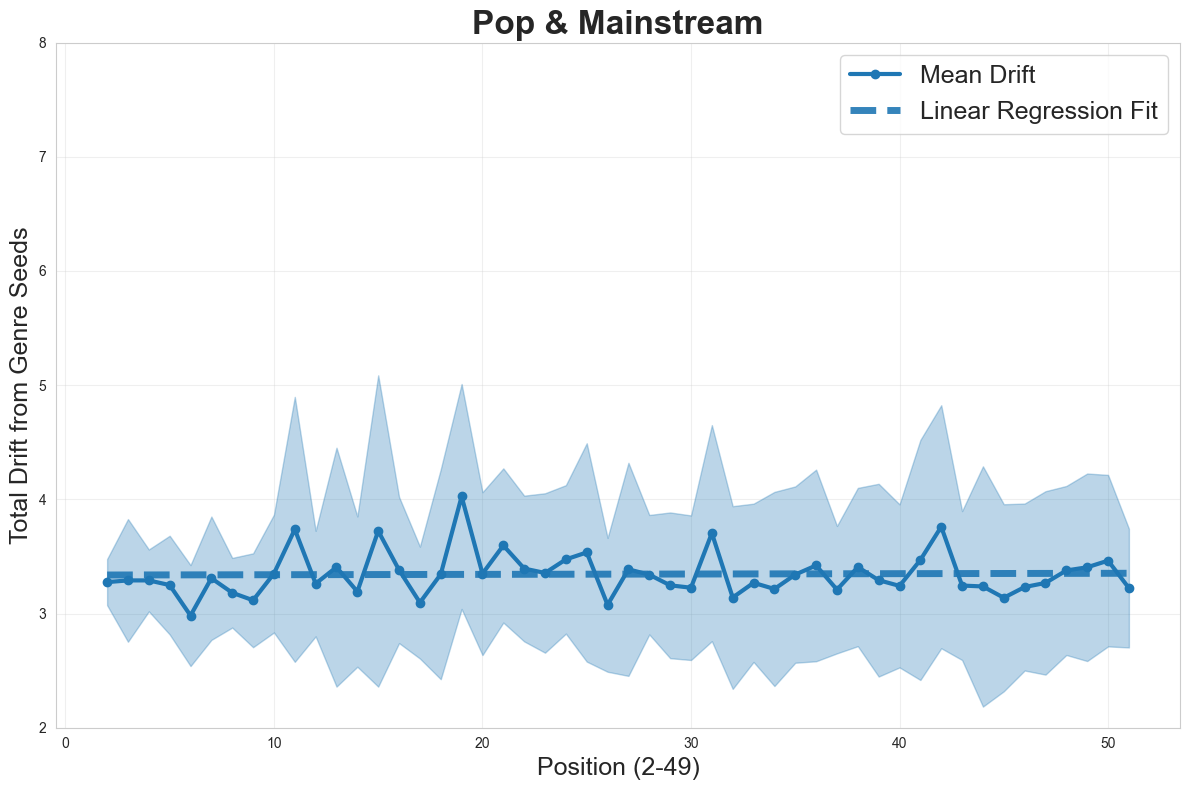

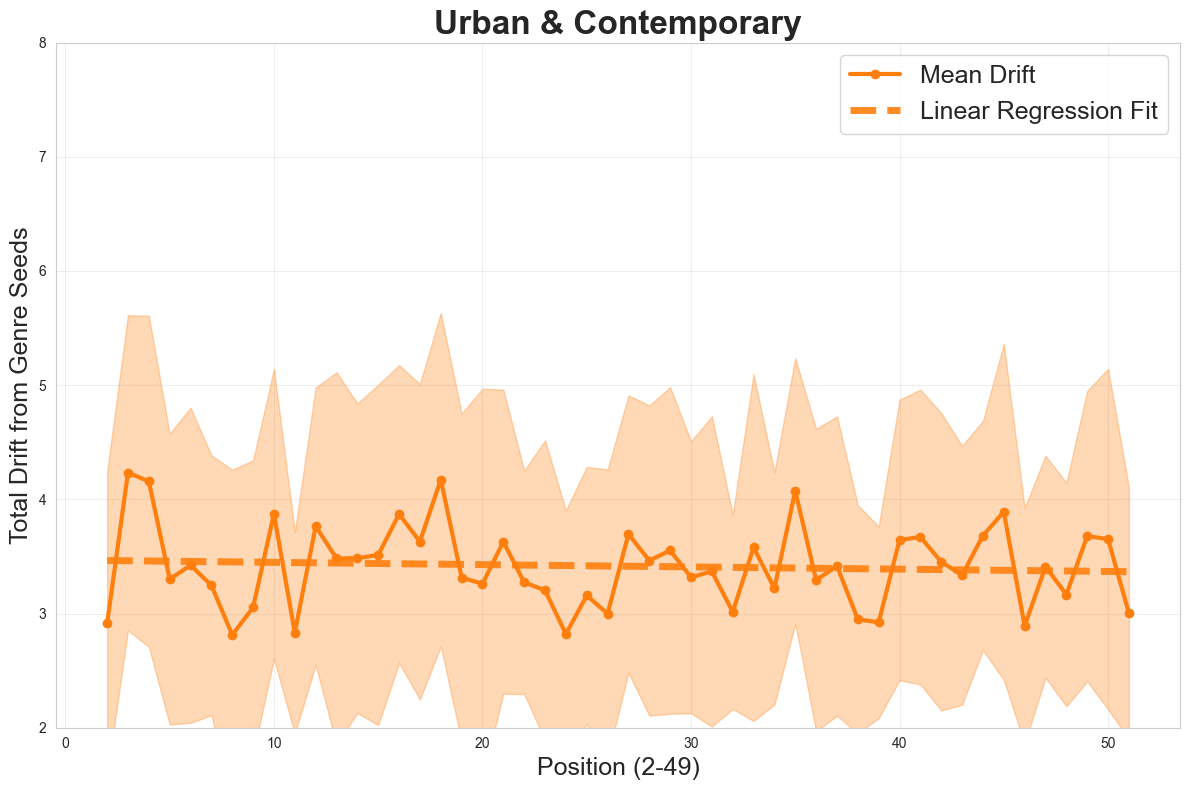

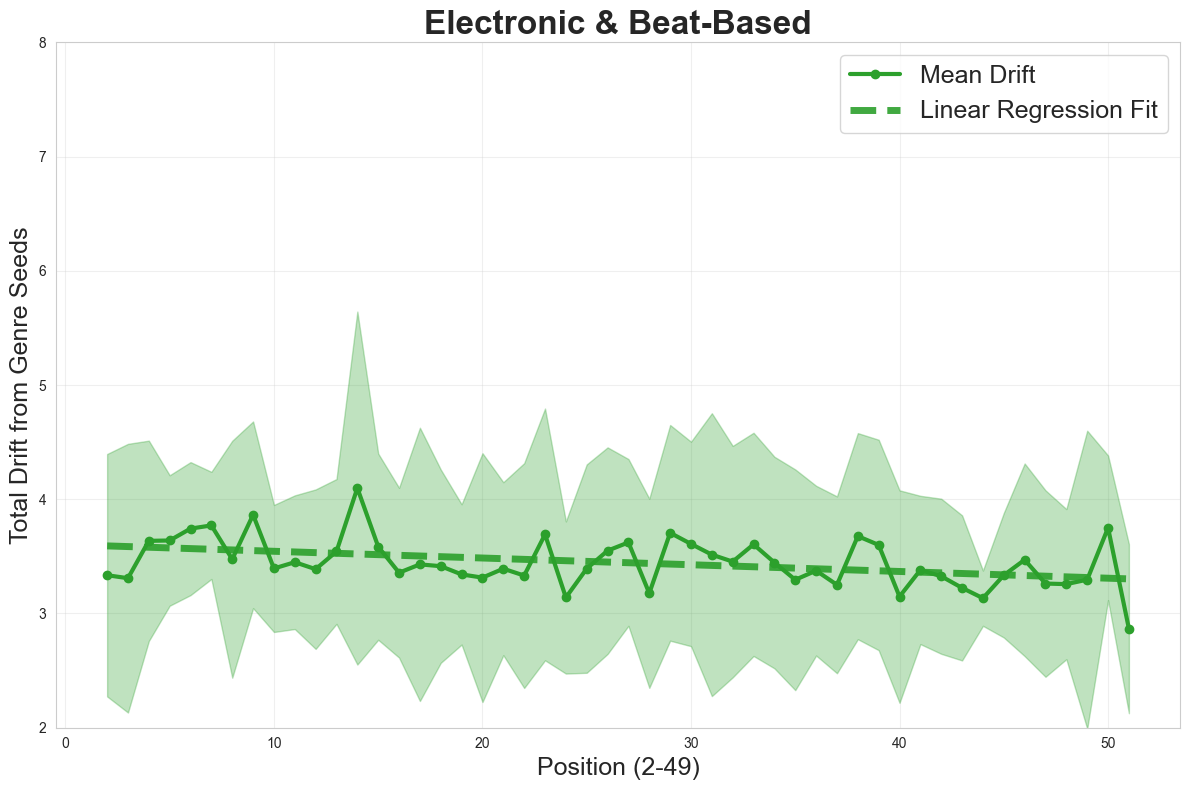

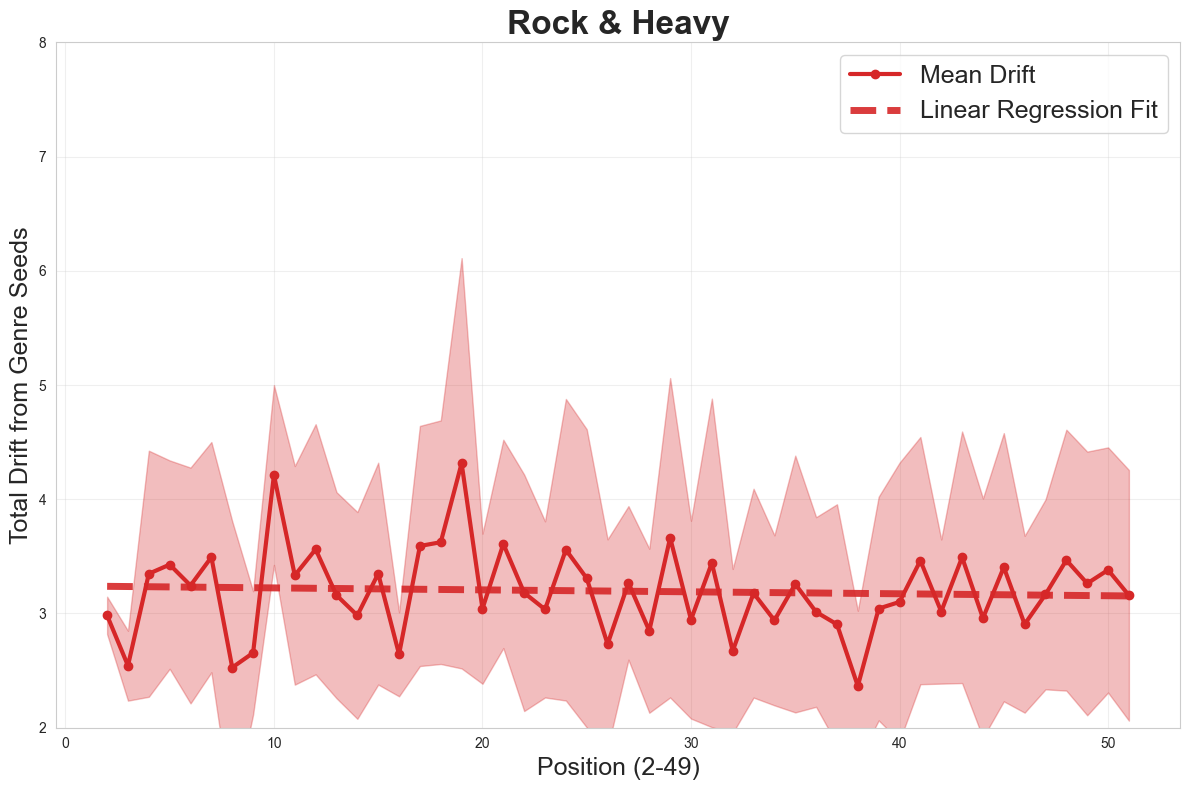

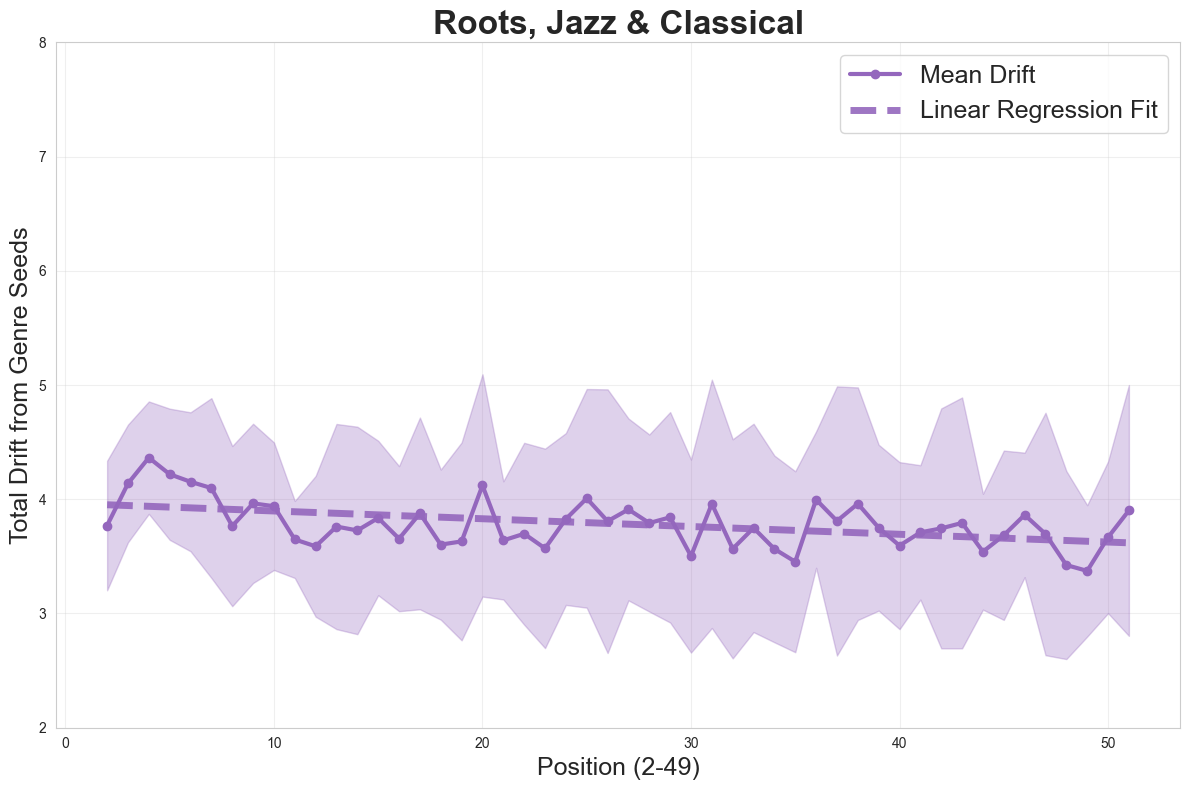

In [38]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Same colors as original plot (tab10 palette)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Genre 1-5
genres = sorted(drifts_global['user_seed_genre'].unique())

# Create SEPARATE figure for EACH genre WITH SAME COLOR REGRESSION LINE
for i, genre in enumerate(genres):
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    # LINEAR REGRESSION for this genre
    slope, intercept, r_value, p_value, std_err = linregress(
        genre_data['position'], genre_data['mean']
    )
    
    plt.figure(figsize=(12, 8))
    
    # Plot mean line + shaded std region (YOUR ORIGINAL - genre color)
    plt.plot(genre_data['position'], genre_data['mean'], 
             marker='o', linewidth=3, color=colors[i],
             label="Mean Drift")
    
    # Shaded std region (mean ± 1 std - SAME genre color)
    plt.fill_between(genre_data['position'], 
                     genre_data['mean'] - genre_data['std'], 
                     genre_data['mean'] + genre_data['std'], 
                     color=colors[i], alpha=0.3)
    
    # NEW: REGRESSION LINE (SAME GENRE COLOR, bold dashed)
    x_reg = np.linspace(genre_data['position'].min(), genre_data['position'].max(), 100)
    y_reg = slope * x_reg + intercept
    plt.plot(x_reg, y_reg, color=colors[i], linestyle='--', linewidth=5, alpha=0.9,
             label='Linear Regression Fit')
    
    # Formatting (same as original)
    # plt.axvline(x=1.5, color='k', ls='--', lw=2, alpha=0.7, label='Dual Seeds End')
    plt.xlabel('Position (2-49)', fontsize=18)
    plt.ylabel('Total Drift from Genre Seeds', fontsize=18)
    plt.title(f'{genre_mapping[int(genre)]}', 
              fontsize=24, fontweight='bold')
    plt.legend(fontsize=18)
    plt.ylim(2, 8)
    plt.grid(True, alpha=0.3)
    
    # SAVE each genre plot
    plt.tight_layout()
    plt.savefig(fr'drift_result\rubber_band_regression_genre_{int(genre)}_{genre_mapping[int(genre)]}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


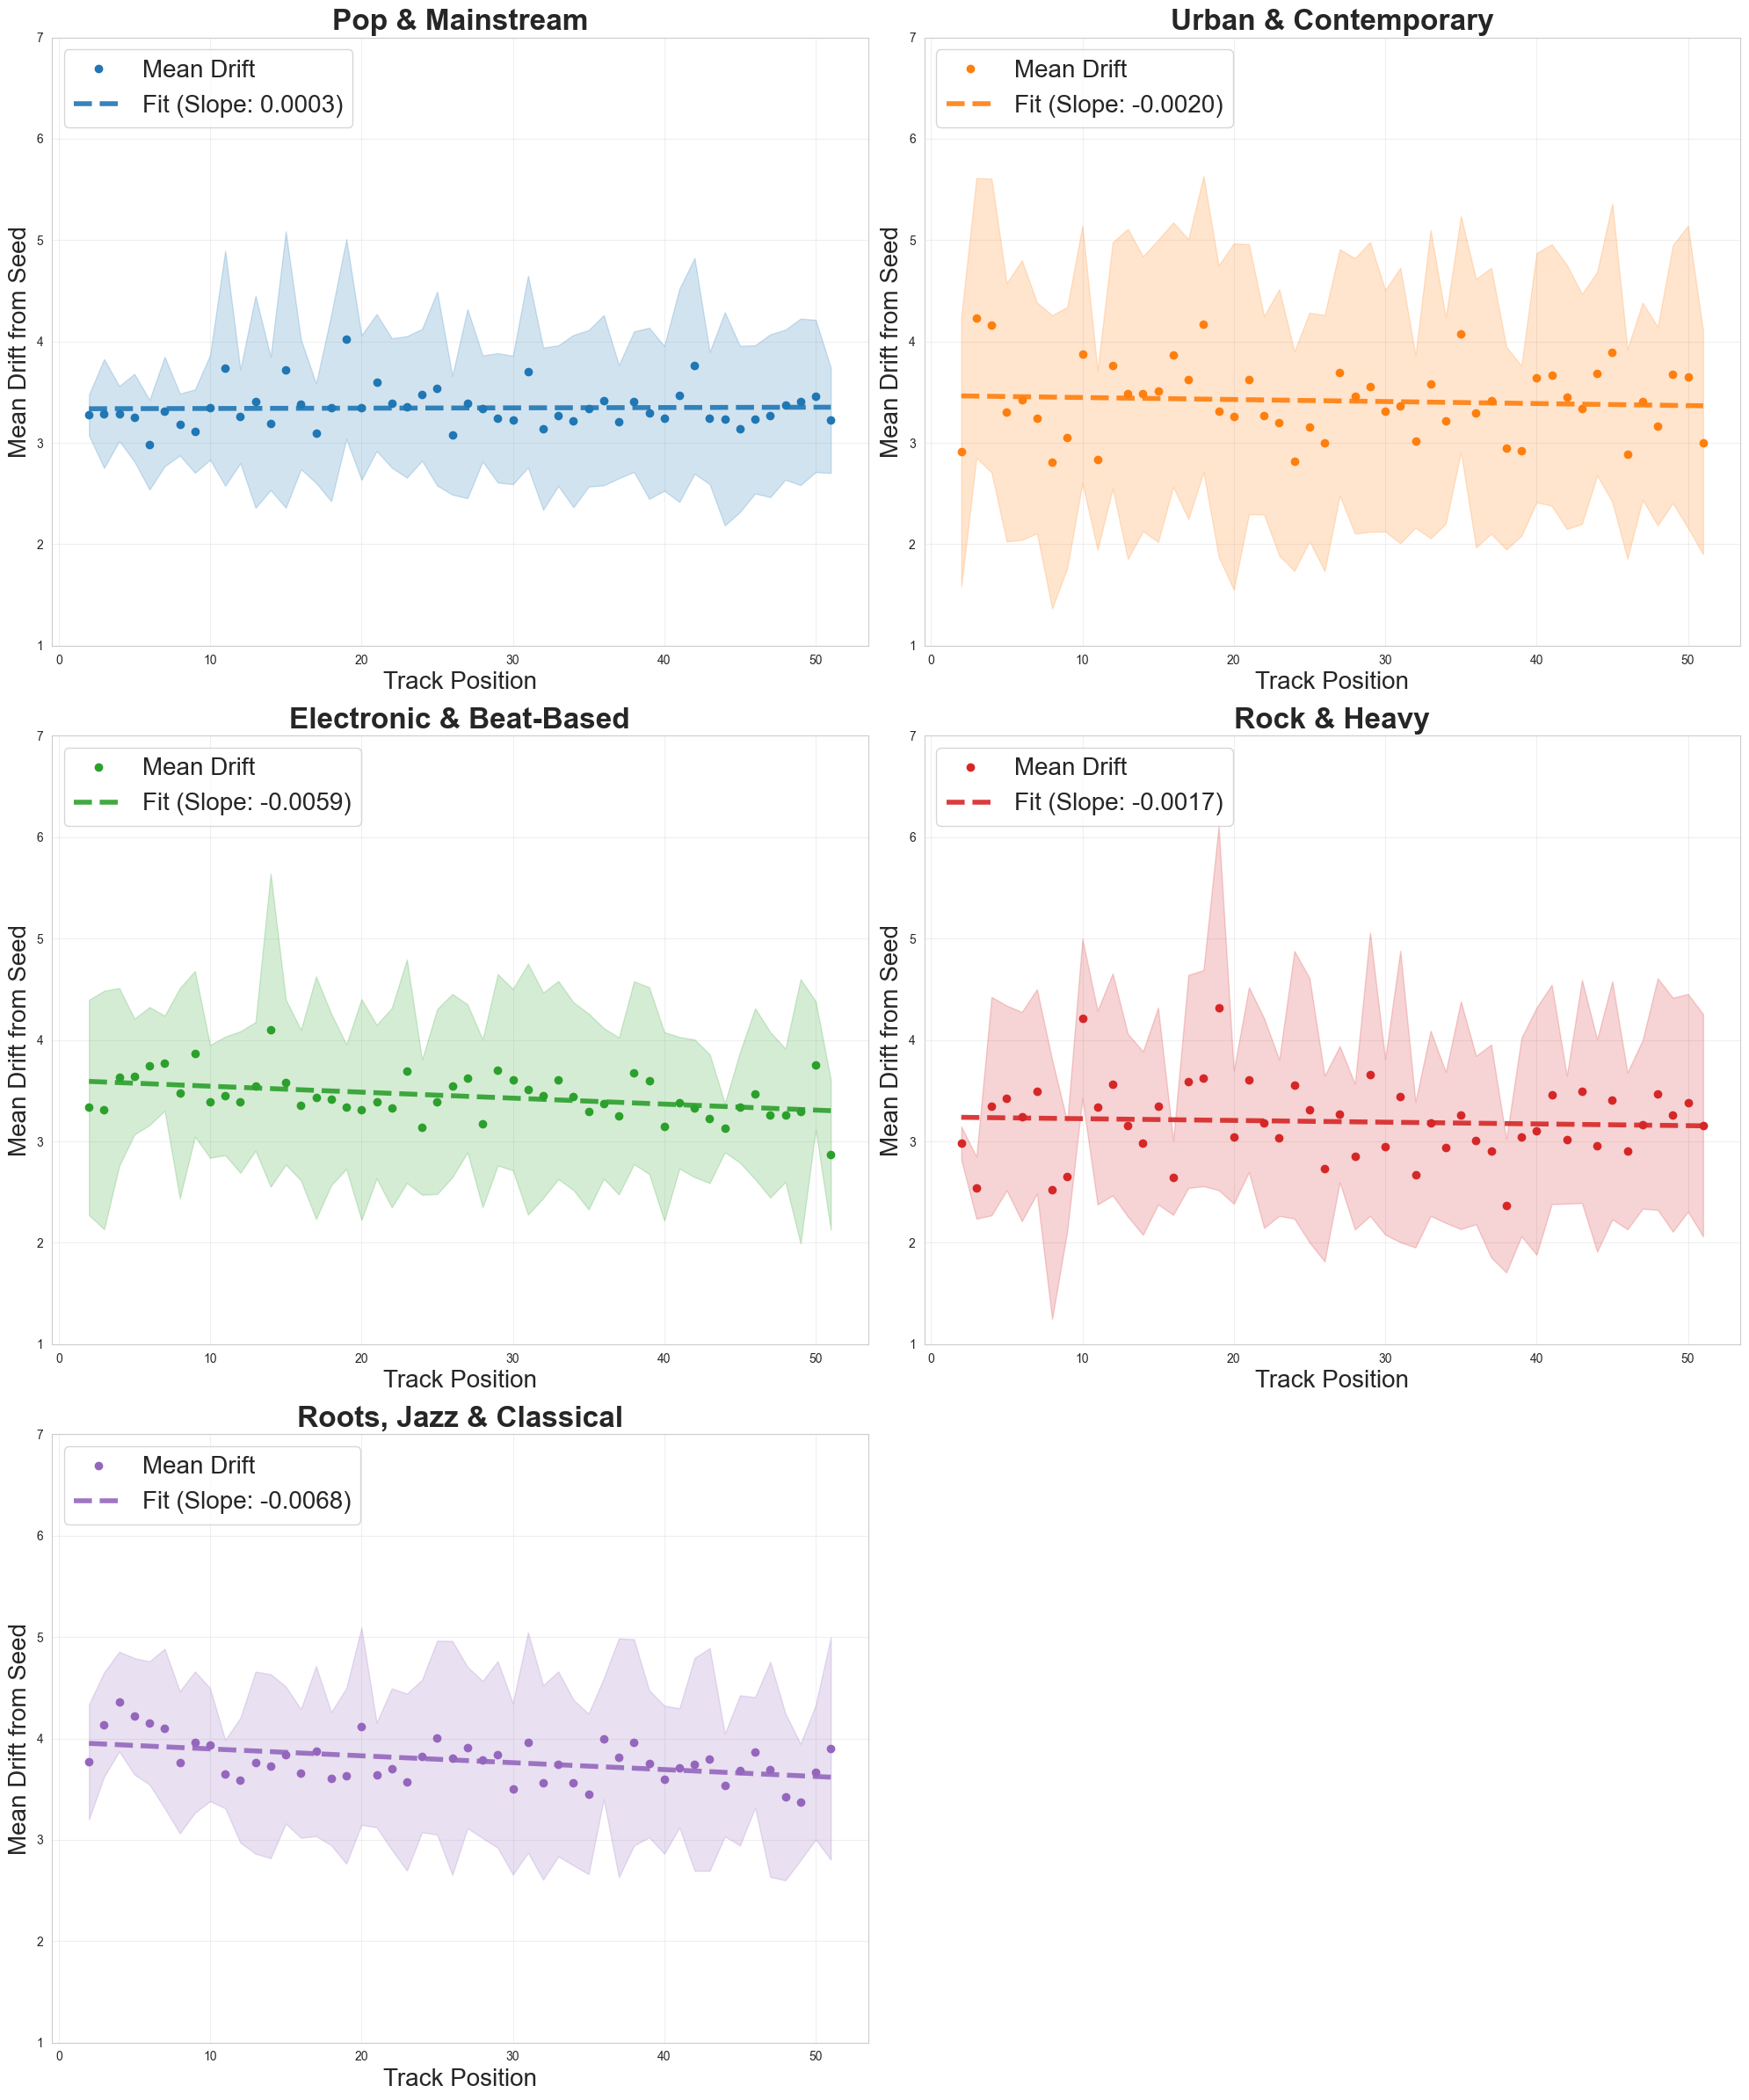

In [45]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Configuration
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
genres = sorted(drifts_global['user_seed_genre'].unique())
n_genres = len(genres)
n_cols = 2
n_rows = (n_genres + 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 8))
axes = axes.flatten()

for i, genre in enumerate(genres):
    ax = axes[i]
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    # Linear Regression
    slope, intercept, r_value, p_value, std_err = linregress(
        genre_data['position'], genre_data['mean']
    )
    
    # Plot Mean + Std Shading
    ax.plot(genre_data['position'], genre_data['mean'], 
             marker='o', linewidth=0, color=colors[i],
             label="Mean Drift")
    
    ax.fill_between(genre_data['position'], 
                     genre_data['mean'] - genre_data['std'], 
                     genre_data['mean'] + genre_data['std'], 
                     color=colors[i], alpha=0.2)
    
    # Regression Line
    x_reg = np.linspace(genre_data['position'].min(), genre_data['position'].max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, color=colors[i], linestyle='--', linewidth=4, alpha=0.9,
             label=f'Fit (Slope: {slope:.4f})')
    
    # Formatting
    ax.set_xlabel('Track Position', fontsize=20)
    ax.set_ylabel('Mean Drift from Seed', fontsize=20)
    ax.set_title(f'{genre_mapping[int(genre)]}', fontsize=24, fontweight='bold')
    ax.legend(fontsize=20, loc='upper left')
    ax.set_ylim(1, 7)
    ax.grid(True, alpha=0.3)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig(r'drift_result\combined_rubber_band_regression.png', dpi=300, bbox_inches='tight')
plt.show()

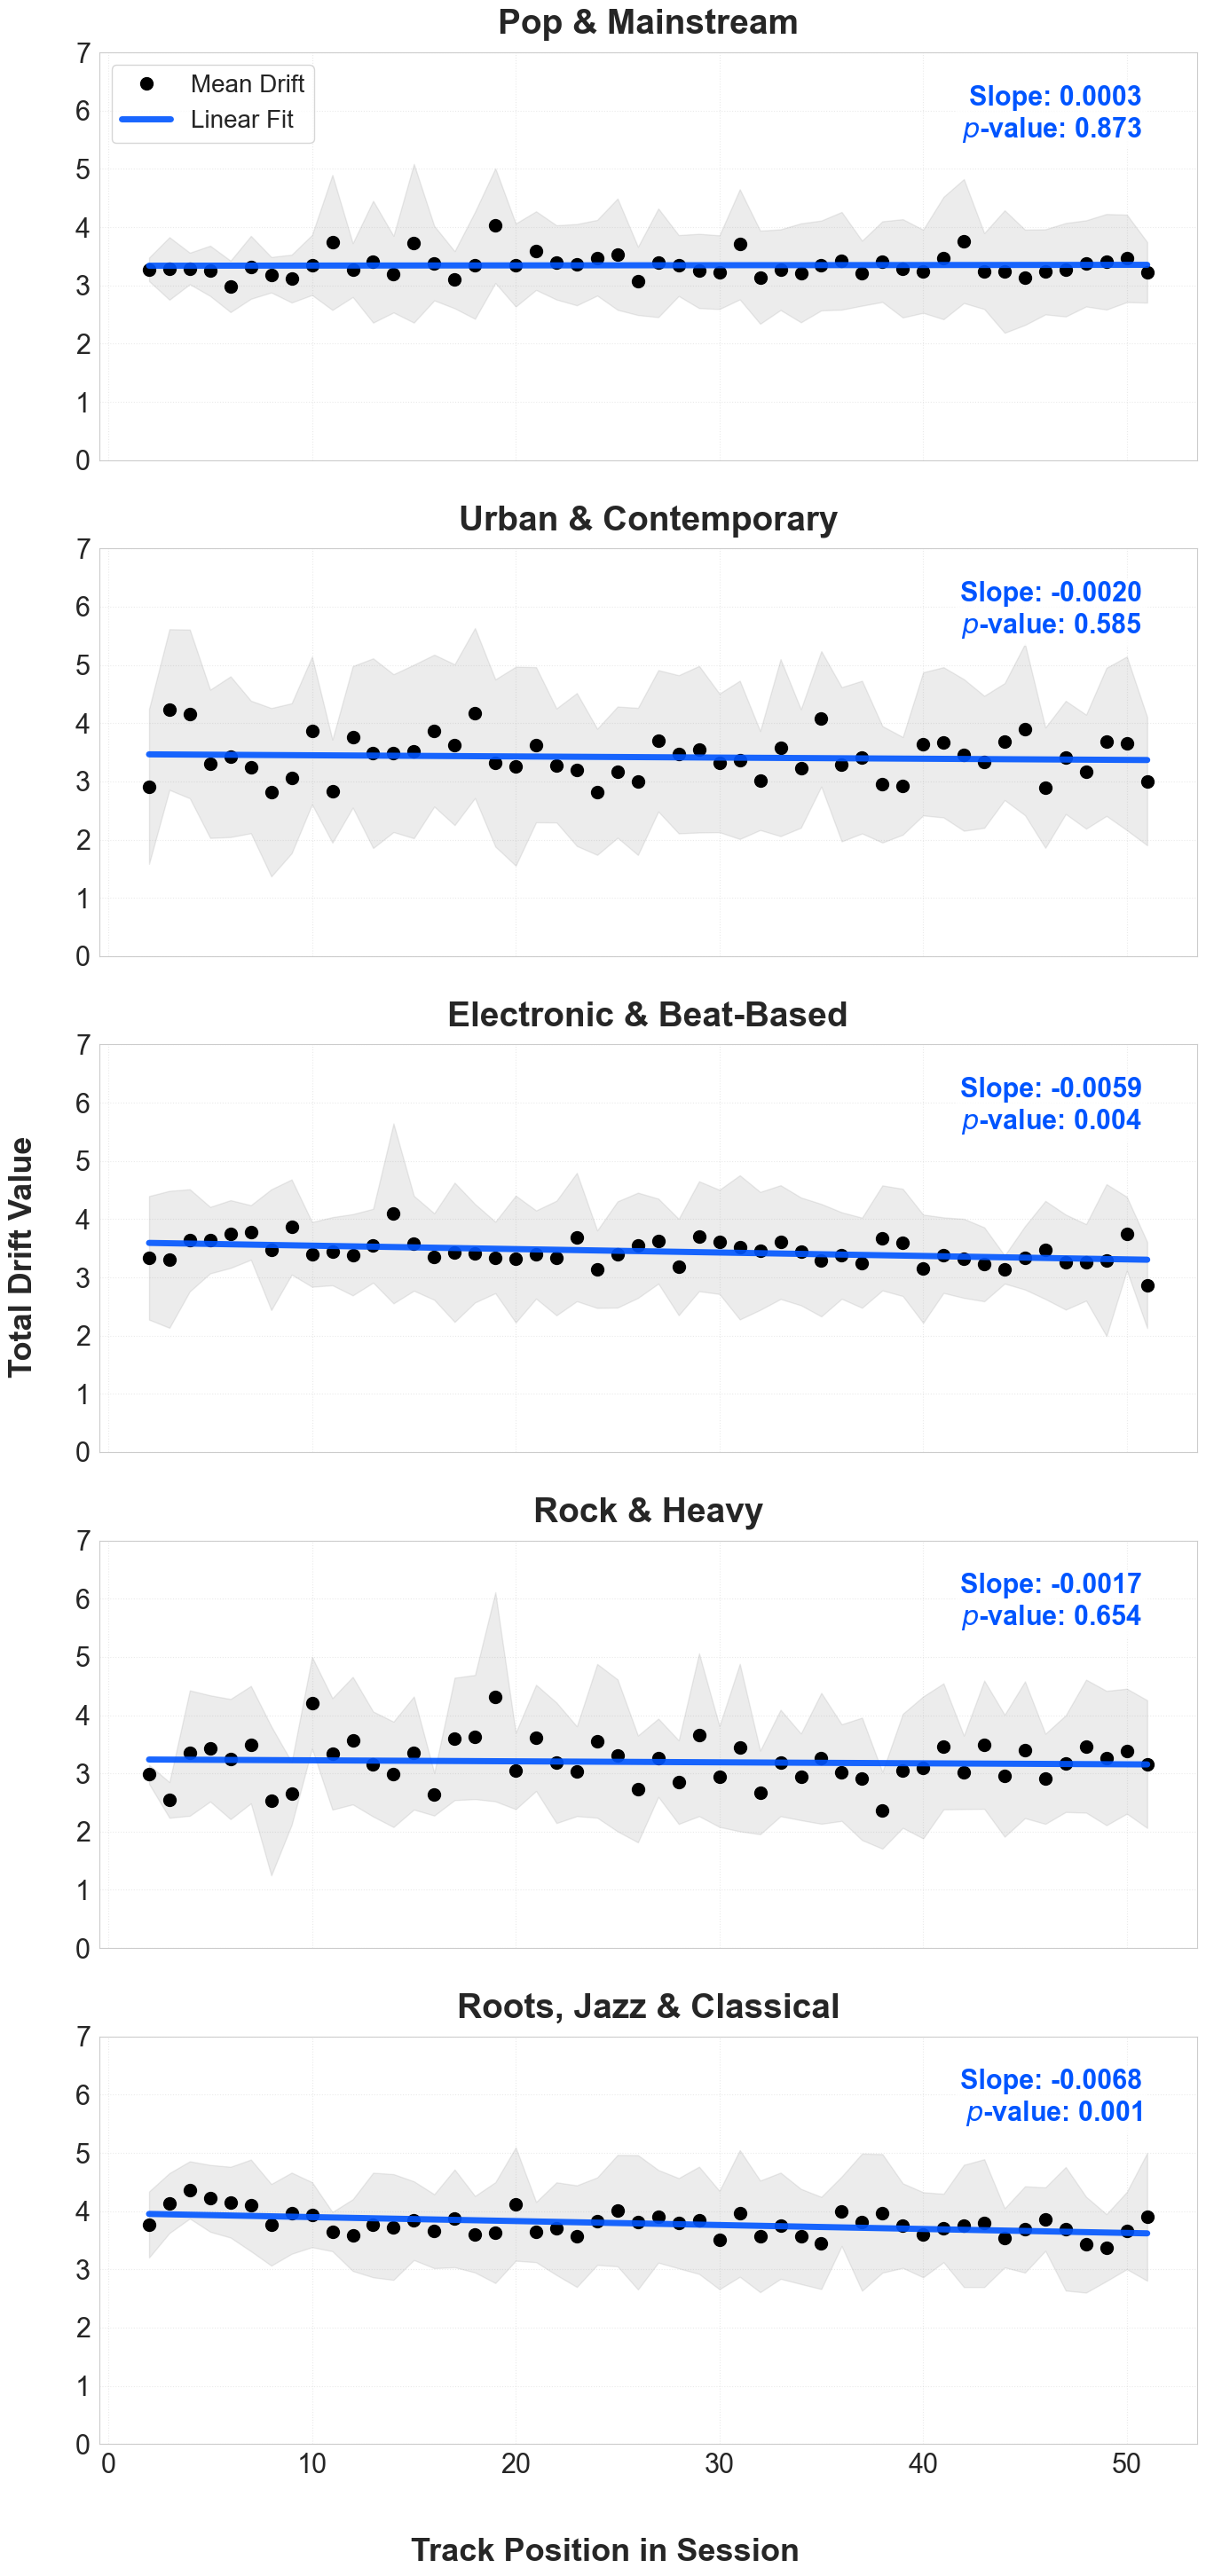

In [48]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Configuration
genres = sorted(drifts_global['user_seed_genre'].unique())
n_genres = len(genres)
n_cols = 1
n_rows = n_genres

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 22})

for i, genre in enumerate(genres):
    ax = axes[i]
    genre_data = drift_stats[drift_stats['user_seed_genre'] == genre]
    
    # Linear Regression
    slope, intercept, r_value, p_value, std_err = linregress(
        genre_data['position'], genre_data['mean']
    )
    
    # Plot Mean Points (Black)
    ax.plot(genre_data['position'], genre_data['mean'], 
             marker='o', markersize=10, linewidth=0, color='black',
             label="Mean Drift")
    
    # Std Deviation Shading
    ax.fill_between(genre_data['position'], 
                     genre_data['mean'] - genre_data['std'], 
                     genre_data['mean'] + genre_data['std'], 
                     color='gray', alpha=0.15)
    
    # Highlighted Regression Line (Royal Blue)
    x_reg = np.linspace(genre_data['position'].min(), genre_data['position'].max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, color='#0055ff', linestyle='-', linewidth=5, alpha=0.9,
             label='Linear Fit')
    
    # ADD DATA LABELS (Slope & P-Value)
    # Using a coordinate transform to place text in the upper right relative to the axes
    stats_text = f"Slope: {slope:.4f}\n$p$-value: {p_value:.3f}"
    ax.text(0.95, 0.92, stats_text, transform=ax.transAxes, 
            verticalalignment='top', horizontalalignment='right',
            fontsize=22, fontweight='bold', color='#0055ff',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Title and Formatting
    ax.set_title(f'{genre_mapping[int(genre)]}', fontsize=28, fontweight='bold', pad=15)
    ax.set_ylim(0, 7) 
    ax.grid(True, linestyle=':', alpha=0.4)
    
    # Only show legend on the first plot to avoid redundancy
    if i == 0:
        ax.legend(fontsize=20, loc='upper left', frameon=True)

# Shared Labels
fig.text(0.5, 0.01, 'Track Position in Session', ha='center', fontsize=26, fontweight='bold')
fig.text(0.02, 0.5, 'Total Drift Value', va='center', rotation='vertical', fontsize=26, fontweight='bold')

for ax in axes:
    ax.label_outer()

plt.tight_layout(rect=[0.05, 0.03, 1, 0.98])
# plt.savefig(r'drift_result\final_annotated_regression.png', dpi=300, bbox_inches='tight')
plt.show()

## **Test for Homoscedaticity**

In [40]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

print("\nBREUSCH-PAGAN TEST (Regression Homoscedasticity)")
print("="*60)

bp_results = []
for genre in sorted(drifts_global['user_seed_genre'].unique()):
    genre_data = drifts_global[drifts_global['user_seed_genre'] == genre]
    position_means = genre_data.groupby('position')['total_drift'].mean()
    
    # Simple linear regression for BP test
    X = sm.add_constant(position_means.index)
    model = sm.OLS(position_means.values, X).fit()
    
    # CORRECT: Use model.resid for OLSResults
    residuals = model.resid
    
    # Breusch-Pagan test
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(residuals, X)
    
    bp_results.append({
        'genre': genre,
        'genre_name': genre_mapping[genre],
        'bp_stat': bp_stat,
        'bp_pvalue': bp_pvalue,
        'homoscedastic': bp_pvalue > 0.05
    })

bp_df = pd.DataFrame(bp_results)
print(bp_df.round(4))



BREUSCH-PAGAN TEST (Regression Homoscedasticity)
   genre               genre_name  bp_stat  bp_pvalue  homoscedastic
0      1         Pop & Mainstream   0.7561     0.3845           True
1      2     Urban & Contemporary   3.9031     0.0482          False
2      3  Electronic & Beat-Based   0.0227     0.8803           True
3      4             Rock & Heavy   3.2351     0.0721           True
4      5  Roots, Jazz & Classical   2.3521     0.1251           True


## COMPLETE STATISTICAL VALIDATION: REGRESSION INTEGRITY

### **Breusch-Pagan Test Results ($H_0$: Constant Variance)**

| Genre | Name | BP Stat | **p-value** | **Homoscedastic?** |
|-------|------|---------|-------------|-------------------|
| **1** | **Pop & Mainstream** | 0.7561 | **0.3845** | ✅ **YES** |
| 2 | Urban & Contemporary | 3.9031 | **0.0482** | ❌ **NO** |
| **3** | **Electronic & Beat-Based** | 0.0227 | **0.8803** | ✅ **YES** |
| 4 | Rock & Heavy | 3.2351 | **0.0721** | ✅ **YES** |
| **5** | **Roots, Jazz & Classical** | 2.3521 | **0.1251** | ✅ **YES** |

---

## 🎯 Key Statistical Findings

**Homoscedasticity Validation (Breusch-Pagan Test)**

* **Mixed Variance Profiles:** 4 out of 5 genres satisfy the assumption of constant variance ($p > 0.05$), ensuring the reliability of the OLS regression coefficients and standard errors for those categories.
* **Electronic ($p=0.8803$) & Pop ($p=0.3845$):** Demonstrate the highest statistical health, with residuals evenly distributed across all track positions.
* **Urban & Contemporary ($p=0.0482$):** Formally fails the homoscedasticity test at the $\alpha = 0.05$ threshold. This suggests that "drift volatility" in Urban seeds is position-dependent, with the error variance changing as the session progresses.
* **Rock & Heavy ($p=0.0721$):** Borderline but remains statistically valid for standard linear inference.